In [58]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt

In [59]:
DAY = "20200728"

In [60]:
raw_df = pd.read_csv(f"tick_2330/tick_2330_{DAY}.csv")
raw_df.head()

,t,sym,px,qty,b5sz,b4sz,b3sz,b2sz,b1sz,b5px,...,a1px,a2px,a3px,a4px,a5px,a1sz,a2sz,a3sz,a4sz,a5sz
0,2020-07-28D09:00:00.225798000,2330,4640000,13911,315,95,482,132,621,4620000,...,4645000,4650000,4655000,4660000,4665000,1831,1264,548,4108,10290
1,2020-07-28D09:00:00.247359000,2330,0,0,315,95,482,132,621,4620000,...,4645000,4650000,4655000,4660000,4665000,1831,1265,548,4108,10290
2,2020-07-28D09:00:00.247595000,2330,0,0,315,95,482,132,621,4620000,...,4645000,4650000,4655000,4660000,4665000,1831,1265,548,4108,10105
3,2020-07-28D09:00:00.337188000,2330,0,0,315,95,482,132,627,4620000,...,4645000,4650000,4655000,4660000,4665000,1831,1265,548,4108,10105
4,2020-07-28D09:00:00.340030000,2330,0,0,315,95,482,132,630,4620000,...,4645000,4650000,4655000,4660000,4665000,1831,1265,548,4108,10105


In [61]:
#Calculate VOI
def delta_vtb(rows):
    row0 ,row1 = rows.iloc[0], rows.iloc[1]
    if np.less(row1["b1px"], row0["b1px"]):
        return 0
    if np.equal(row1["b1px"], row0["b1px"]):
        return np.subtract(row1["b1sz"], row0["b1sz"])
    return row1["b1sz"]

def delta_vta(rows):
    row0 ,row1 = rows.iloc[0], rows.iloc[1]
    if np.less(row1["a1px"], row0["a1px"]):
        return row1["a1sz"]
    if np.equal(row1["a1px"], row0["a1px"]):
        return np.subtract(row1["a1sz"], row0["a1sz"])
    return 0

def chunker(seq):
    return (seq.iloc[pos:pos + 2] for pos in range(0, len(seq)-1))

In [62]:
drop_ls = ['b5sz','b4sz','b3sz','b2sz','b5px','b4px','b3px','b2px','a2px','a3px','a4px','a5px','a2sz','a3sz','a4sz','a5sz']

def Preprocessing(df):
    filter_ = (df['sym'] == 2330)
    df = df[filter_]
    start = df['t'] >= f'{DAY[:4]}-{DAY[4:6]}-{DAY[6:]}D09:05:00.000000000'
    end = df['t'] <= f'{DAY[:4]}-{DAY[4:6]}-{DAY[6:]}D13:25:00.000000000'
    df = df[(start&end)]
    df = df.drop(drop_ls, axis = 1)
    return df

df = Preprocessing(raw_df)

In [63]:
df.head()

,t,sym,px,qty,b1sz,b1px,a1px,a1sz
11192,2020-07-28D09:05:00.006032000,2330,4660000,2,461,4655000,4660000,1369
11193,2020-07-28D09:05:00.044259000,2330,4660000,1,461,4655000,4660000,1368
11194,2020-07-28D09:05:00.056901000,2330,0,0,462,4655000,4660000,1368
11195,2020-07-28D09:05:00.066693000,2330,0,0,462,4655000,4660000,1368
11196,2020-07-28D09:05:00.109818000,2330,4660000,2,462,4655000,4660000,1366


In [64]:
current_px = current_qty = 0
for index, row in df.iterrows():
    if row["px"] == 0:
        df.set_value(index, 'px', current_px)
    else:
        current_px = row["px"]
    if row["qty"] == 0:
        df.set_value(index, 'qty', current_qty)
    else:
        current_qty = row["qty"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [65]:
df.head()

,t,sym,px,qty,b1sz,b1px,a1px,a1sz
11192,2020-07-28D09:05:00.006032000,2330,4660000,2,461,4655000,4660000,1369
11193,2020-07-28D09:05:00.044259000,2330,4660000,1,461,4655000,4660000,1368
11194,2020-07-28D09:05:00.056901000,2330,4660000,1,462,4655000,4660000,1368
11195,2020-07-28D09:05:00.066693000,2330,4660000,1,462,4655000,4660000,1368
11196,2020-07-28D09:05:00.109818000,2330,4660000,2,462,4655000,4660000,1366


In [66]:
VOI = list()

for group in chunker(df):
    VOI.append(delta_vtb(group) - delta_vta(group))

In [67]:
len(VOI)

143439

In [68]:
#Calculate LOG_RETURN
def log_return(rows):
    return np.log(rows.iloc[0]["px"]/rows.iloc[1]["px"])

log_list = list()
count = 0
for group in chunker(df):
    log_list.append(log_return(group))

In [69]:
VOI_np = np.array(VOI)

unique, counts = np.unique(VOI_np, return_counts=True)
VOI_count = dict(zip(unique, counts))

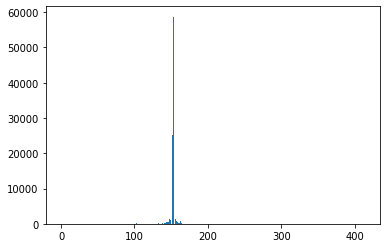

In [70]:
plt.bar(range(len(VOI_count)), list(VOI_count.values()), align='center')
plt.show()

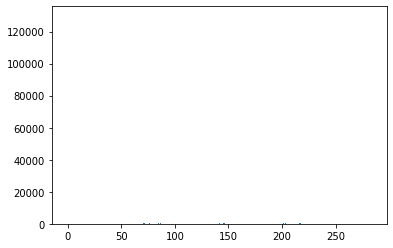

In [71]:
log_np = np.array(log_list)

unique, counts = np.unique(log_np, return_counts=True)
log_count = dict(zip(unique, counts))
plt.bar(range(len(log_count)), list(log_count.values()), align='center')
plt.show()

In [72]:
#逐筆比較
import statsmodels.api as sm
series_dict={'X':VOI,'y':log_list}
cal=pd.DataFrame(series_dict)
X=cal[['X']]
y=cal[['y']]
x = sm.add_constant(X)
ols_results = sm.OLS(y, x).fit()
print(ols_results.summary())

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     15.15
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           9.91e-05
Time:                        15:26:13   Log-Likelihood:             9.2304e+05
No. Observations:              143439   AIC:                        -1.846e+06
Df Residuals:                  143437   BIC:                        -1.846e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.437e-07   1.03e-06      0.628      0.5

In [73]:
log_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0010735374085241852,
 -0.00107353740852408,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0010735374085241852,
 -0.00107353740852408,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0010735374085241852,
 0.0,
 -0.00107353740852408,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0010735374085241852,
 0.0,
 -0.00107353740852408,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0010735374085241852,
 0.0,
 -0.00107353740852408,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0010735374085241852,
 -0.00107353740852408,
 0.0,
 0.0,
 0.0,
 0.0